# Infrared and Raman spectra using  DFT+U+V

Using different functionals might be needed in different real case scenario. Here, we demonstrate how the workflows in the package can be employed to predict the infrared and Raman spectra using both DFT and DFT+U+V.

We will make use of LiCoO{sub}`2` for the demonstration.

Let's get started!

In [3]:
from local_module import load_temp_profile

# If you download this file, you can run it with your own profile.
# Put these lines instead:
# from aiida import load_profile
# load_profile()
data = load_temp_profile(
    name="functionals-tutorial",
    add_computer=True,
    add_pw_code=True,
    add_sssp=True,
)

## Creating the structure

Let's define the LiCoO{sub}`2` structure.

In [4]:
from aiida.orm import StructureData

a, b, c, d = 1.4060463552647, 0.81178124180108, 4.6012019181836, 1.6235624832021
cell = [[a, -b, c], [0.0, d, c], [-a, -b, c]]
sites = [
    ['Co', 'Co', (0, 0, 0)],
    ['O', 'O', (0, 0, 3.6020728736387)],
    ['O', 'O', (0, 0, 10.201532881212)],
    ['Li', 'Li', (0, 0, 6.9018028772754)],
]
structure = StructureData(cell=cell)

for site in sites:
    structure.append_atom(position=site[2], symbols=site[0], name=site[1])

structure.store()

<StructureData: uuid: a489219a-22da-4135-879d-9483bd1380e3 (pk: 87)>


## Spectra using PBEsol

Let's first import the WorkChain and run it using 'simple' __PBEsol__!

As usual, we use the `get_builder_from_protocol` to get a __prefilled__ builder with __all inputs__. These inputs should be considered __not as converged parameters__, but as a good starting point. You may also need to tweak some parameters, e.g. add magnetization etc., depending on your case. 

In [5]:
from aiida.plugins import WorkflowFactory
from aiida.engine import run_get_node


IRamanSpectraWorkChain = WorkflowFactory("vibroscopy.spectra.iraman")

# To make the calculations run faster
scf_overrides = {'scf':{'pw':{'parameters':{'SYSTEM':{'ecutwfc':30, 'ecutrho':30*8}}}}}

builder = IRamanSpectraWorkChain.get_builder_from_protocol(
    code=data.pw_code,
    structure=structure,
    protocol="fast",
    overrides={'dielectric':scf_overrides, 'phonon':scf_overrides}
)

results, calc = run_get_node(builder)

08/25/2023 06:55:26 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [106|IRamanSpectraWorkChain|run_spectra]: submitting `HarmonicWorkChain` <PK=108>
08/25/2023 06:55:26 PM <799519> aiida.engine.processes.functions: [WARNING] function `generate_preprocess_data` has invalid type hints: unsupported operand type(s) for |: 'AbstractNodeMeta' and 'NoneType'
08/25/2023 06:55:26 PM <799519> aiida.engine.processes.functions: [WARNING] function `generate_phonopy_data` has invalid type hints: unsupported operand type(s) for |: 'AbstractNodeMeta' and 'NoneType'
08/25/2023 06:55:27 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [108|HarmonicWorkChain|run_phonon]: submitting `PhononWorkChain` <PK=114>
08/25/2023 06:55:27 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [108|HarmonicWorkChain|run_dielectric]: submitting `DielectricWorkChain` <PK=118>
08/25/2023 06:55:28 PM <799519> aiida.orm.nodes.process.wo

## Powder Raman spectra using PBEsol

Let's plot the powder Raman spectra computed using PBEsol.

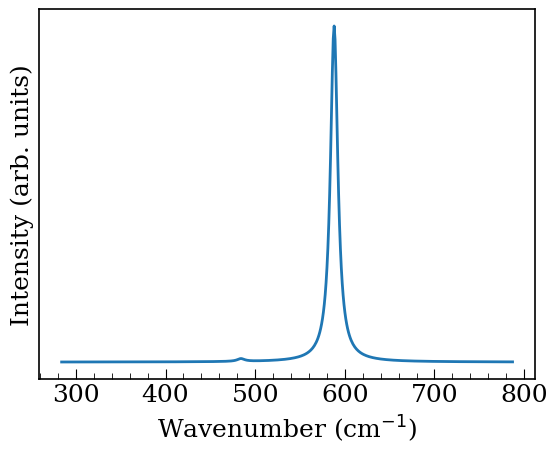

In [6]:
from aiida_vibroscopy.utils.plotting import get_spectra_plot

vibro = calc.outputs.vibrational_data.numerical_accuracy_4
polarized_intensities, unpolarized_intensities, frequencies_pbesol, labels = vibro.run_powder_raman_intensities(frequency_laser=532, temperature=300)

total_intensities_pbesol =  polarized_intensities + unpolarized_intensities
plt = get_spectra_plot(frequencies_pbesol, total_intensities_pbesol)
plt.show()

## Spectra using PBEsol+U+V


### Defining the `HubbardStructureData`

The Hubbard input should be specified alongside with the structural data, in a unique data called `HubbardStructureData`. Refer to the aiida-quantumespresso for more insights. What you need to know is that you can run a full Hubbard corrected calculations by just specifying the HubbardStructureData _as an input for the structure_; this will work _in any workchain_ of the package!

::: {attention}
If you want to compute self-consistently the Hubbard parameters in automated fashion, please have a look at our __aiida-quantumespresso-hp__ plugin, fully automated and parallelisable! The `SelfConsistentHubbardWorkChain` will deliver for you a __fully relaxed__ structure with __fully self-consistent ab-initio__ Hubbard parameters!
:::

::: {note}
For this demonstration we will not compute the Hubbard parameters ab-initio. These ones that we will use were computed beforehand in a separate job run in order to demonstrate quickly the properties we are interested in.
:::

In [7]:
from aiida_quantumespresso.common.hubbard import Hubbard
from aiida_quantumespresso.data.hubbard_structure import HubbardStructureData

hubbard_list = [
    (0, '3d', 0, '3d', 7.2362, (0, 0, 0), 'V'),
    (0, '3d', 2, '2p', 0.2999, (-1, 0, -1), 'V'),
    (0, '3d', 1, '2p', 0.2999, (0, 0, -1), 'V'),
    (0, '3d', 1, '2p', 0.2999, (-1, 0, 0), 'V'),
    (0, '3d', 2, '2p', 0.2999, (0, -1, -1), 'V'),
    (0, '3d', 2, '2p', 0.2999, (-1, -1, 0), 'V'),
    (0, '3d', 1, '2p', 0.2999, (0, -1, 0), 'V')
]

a, b, c, d = 1.4023265572925, 0.80963361535606, 4.6735772081287, 1.6192672305121
cell = [[a, -b, c], [0.0, d, c], [-a, -b, c]]
sites = [
    ['Co', 'Co', (0, 0, 0)],
    ['O', 'O', (0, 0, 3.6492980821051)],
    ['O', 'O', (0, 0, 10.371433542381)],
    ['Li', 'Li', (0, 0, 7.010365812143)],
]

hubbard_structure = HubbardStructureData(cell=cell, sites=sites)
hubbard_structure.hubbard = Hubbard.from_list(hubbard_list)
hubbard_structure.store()

<HubbardStructureData: uuid: 87553170-f713-4065-a8b0-effccfdc70fb (pk: 455)>

### Running the `IRamanSpectraWorkChain` with the `HubbardStructureData`

Let's run the workchain for IR and Raman using the just defined structure with Hubbard parameters.

In [8]:
builder = IRamanSpectraWorkChain.get_builder_from_protocol(
    code=data.pw_code,
    structure=hubbard_structure,
    protocol="fast",
    overrides={'dielectric':scf_overrides, 'phonon':scf_overrides}
)

results_hubabrd, calc_hubbard = run_get_node(builder)

08/25/2023 07:19:02 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [474|IRamanSpectraWorkChain|run_spectra]: submitting `HarmonicWorkChain` <PK=476>
08/25/2023 07:19:02 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [476|HarmonicWorkChain|run_phonon]: submitting `PhononWorkChain` <PK=482>
08/25/2023 07:19:02 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [476|HarmonicWorkChain|run_dielectric]: submitting `DielectricWorkChain` <PK=486>
08/25/2023 07:19:04 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [486|DielectricWorkChain|run_base_scf]: launching base scf PwBaseWorkChain<511>
08/25/2023 07:19:04 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [511|PwBaseWorkChain|run_process]: launching PwCalculation<515> iteration #1
08/25/2023 07:19:04 PM <799519> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [482|Phonon

## Powder Raman spectra using PBEsol+U+V

Let's plot the powder Raman spectra computed using PBEsol+U+V.

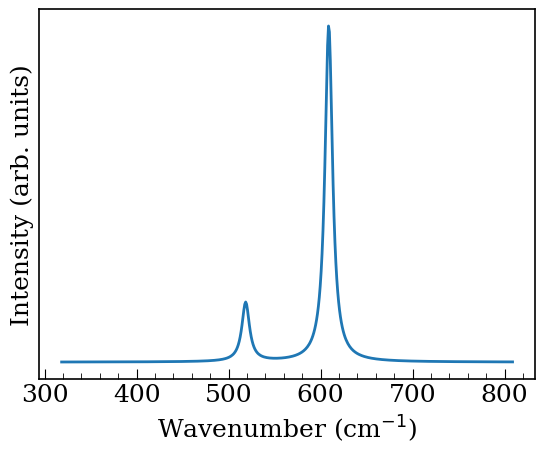

In [9]:
vibro = calc_hubbard.outputs.vibrational_data.numerical_accuracy_4
polarized_intensities, unpolarized_intensities, frequencies_hubbard, labels = vibro.run_powder_raman_intensities(frequency_laser=532, temperature=300)

total_intensities_hubbard =  polarized_intensities + unpolarized_intensities
plt = get_spectra_plot(frequencies_hubbard, total_intensities_hubbard)
plt.show()

## Comparison with experiments

We compare the above results with the experimental results from [M. Inaba et al., _Chem. Lett._, __24__, 889 (__1995__)](https://www.journal.csj.jp/doi/10.1246/cl.1995.889).

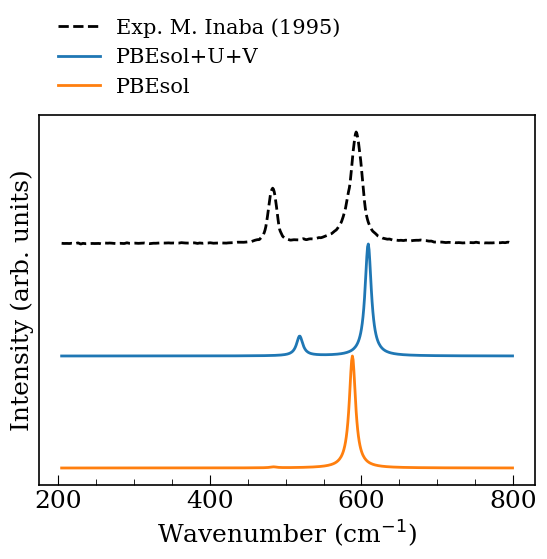

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from aiida_vibroscopy.utils.broadenings import multilorentz

broadening = 10.0

# -----  Canvas
_, ax = plt.subplots() 

# -----  Experiments
converter = lambda s: float(s.decode("UTF-8").replace(",", "."))
x_range, y_range = np.loadtxt("./_static/lico2_raman_exp.txt", unpack=True, converters={0:converter, 1:converter})
y_range = (y_range-y_range.min())/(y_range.max()-y_range.min())
ax.plot(x_range, y_range+2, linewidth=2.0, color='black', linestyle='--', label="Exp. M. Inaba (1995)")  

# ----- PBEsol+U+V
y_range = multilorentz(x_range, frequencies_hubbard, total_intensities_hubbard, broadening)
y_range /= y_range.max()
ax.plot(x_range, y_range+1, linewidth=2.0, linestyle='-', label="PBEsol+U+V")  

# ----- PBEsol
y_range = multilorentz(x_range, frequencies_pbesol, total_intensities_pbesol, broadening)
y_range /= y_range.max()
ax.plot(x_range, y_range+0, linewidth=2.0, linestyle='-', label="PBEsol") 


# ----- Ticks and Labels
ax.set_yticklabels('')
ax.set_yticks([])
ax.tick_params(axis='both', which='both', direction='in')
ax.set_ylabel('Intensity (arb. units)')  # Add a y-label to the axes.
ax.set_xlabel('Wavenumber (cm$^{-1}$)')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# ----- Legend
ax.legend(bbox_to_anchor=(0,1,1,0.1), loc='lower left', frameon=False)

plt.show()

::: {warning}
We are here quite far from concluding something, i.e. which functional is the best. We used __unconverged__ paramaters to fit the time of a tutorial. We should make sure to converge cutoff, k points and electronic charge convergence. 

Moreover, temperature can affect comparison with experiments. In general, though, we can say that thermal expansion would lead to renormalization of the frequencies, usually reducing them. Thus, it is better to overestimate in general the phonon frequencies - although note that this is not a necessary condition.
:::